In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV

In [10]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df=df[['age','default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed']]

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['contact','month','poutcome']
df_encoded = pd.get_dummies(df['default'], prefix='default', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['default']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [11]:
undersample = NearMiss(version=1, n_neighbors_ver3=3)
features, y = undersample.fit_resample(features, y)

In [12]:
# define lists to collect scores
train_scores, test_scores = list(), list()
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start += step

In [13]:
# gebruiken als bron voor de learning rate 
# https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/ 

In [ ]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=1 ,random_state=23).fit(
        train_features, train_targets)

#After the first run we make jumps of 100, 10 and lastly 1 for n_estimator

param_grid = {'learning_rate': [0.1, 0.01, pow(10,-3), pow(10,-4), pow(10,-5), pow(10,-6)]
              , 'n_estimators': range(1,6001,1000),
             'max_depth': [1,2,3,4,5,6,7,8,9]}
grid = GridSearchCV(ensemble,param_grid,refit=True, scoring='roc_auc' ,verbose =2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)
print(grid.best_params_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(test_targets,grid_predictions))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END .....learning_rate=0.1, max_depth=1, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=1, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=1, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=1, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1001; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1001; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1001; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1001; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1001; total time=   2.1s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=2001; total time=   4.3s
[CV] END ..learning_rate=0.1, max_depth=1, n_

[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=2001; total time=  12.0s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=2001; total time=  19.8s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=2001; total time=  15.2s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=2001; total time=  12.0s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=3001; total time=  25.4s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=3001; total time=  19.3s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=3001; total time=  23.2s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=3001; total time=  16.9s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=3001; total time=  18.0s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=4001; total time=  28.2s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=4001; total time=  27.2s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=4001; total time=  27.5s
[CV] END ..learning_rate=0.1

In [18]:
#Boosting the tree and predicting with ROC curve and classification reports
def gradient_boosted_tree(features, targets, learningRate, nEstimator):
    train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
    ensemble = GradientBoostingClassifier(max_depth=1, learning_rate = learningRate, n_estimators= nEstimator ,random_state=23)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True)

    
    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='roc_auc' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))

    ensemble.fit(train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))

In [7]:
#Now we set our n_estimator and learning_rate to the optimal value found in the last grid search
learningRate = 0.1
nEstimator = 5897
maximumDepth = 4

mean cross validation score: 0.908
Confusion Matrix:
[[853  82]
 [203 718]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       935
           1       0.90      0.78      0.83       921

    accuracy                           0.85      1856
   macro avg       0.85      0.85      0.85      1856
weighted avg       0.85      0.85      0.85      1856



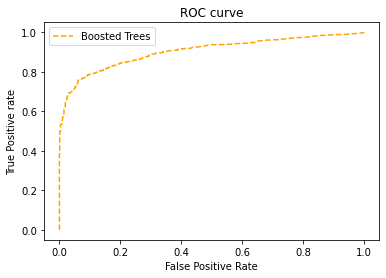

AUC Score: 0.903


In [20]:
gradient_boosted_tree(features, y.values.ravel(), learningRate, nEstimator)

Learning rate: 0.100000, train: 0.849, test: 0.846
Learning rate: 0.010000, train: 0.820, test: 0.823
Learning rate: 0.001000, train: 0.788, test: 0.778
Learning rate: 0.000100, train: 0.773, test: 0.759
Learning rate: 0.000010, train: 0.773, test: 0.759
Learning rate: 0.000001, train: 0.773, test: 0.759


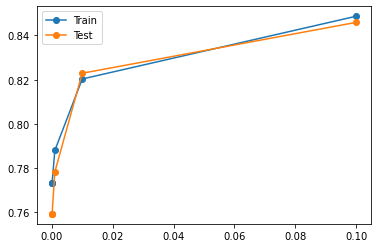

In [36]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)


#Check for overfitting with learning_rate

# define lists to collect scores
train_scores, test_scores = list(), list()

# define the learning rate to evaluate
values = [0.1, 0.01, pow(10,-3), pow(10,-4), pow(10,-5), pow(10,-6)]
# evaluate a decision tree for learning rate
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=1, learning_rate = i, n_estimators=nEstimator, random_state=23).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = roc_auc_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('Learning rate: %.6f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs learning rate
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()


n_estimator: 1, train: 0.773, test: 0.759
n_estimator: 101, train: 0.800, test: 0.801
n_estimator: 201, train: 0.810, test: 0.804
n_estimator: 301, train: 0.809, test: 0.806
n_estimator: 401, train: 0.817, test: 0.818
n_estimator: 501, train: 0.817, test: 0.815
n_estimator: 601, train: 0.818, test: 0.823
n_estimator: 701, train: 0.825, test: 0.829
n_estimator: 801, train: 0.827, test: 0.830
n_estimator: 901, train: 0.829, test: 0.829
n_estimator: 1001, train: 0.835, test: 0.835
n_estimator: 1101, train: 0.837, test: 0.836
n_estimator: 1201, train: 0.841, test: 0.836
n_estimator: 1301, train: 0.842, test: 0.837
n_estimator: 1401, train: 0.842, test: 0.837
n_estimator: 1501, train: 0.843, test: 0.837
n_estimator: 1601, train: 0.844, test: 0.837
n_estimator: 1701, train: 0.844, test: 0.838
n_estimator: 1801, train: 0.844, test: 0.838
n_estimator: 1901, train: 0.844, test: 0.839
n_estimator: 2001, train: 0.844, test: 0.839
n_estimator: 2101, train: 0.844, test: 0.839
n_estimator: 2201, tra

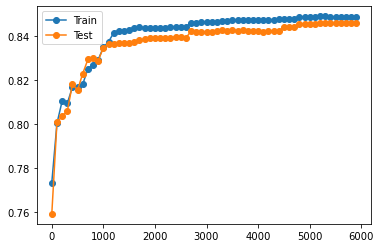

In [37]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)


#Check for overfitting with n_estimators

# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = [i for i in range_with_floats(1, 6001, 100)]
# evaluate a decision tree for estimator
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=1, learning_rate = learningRate, n_estimators=i, random_state=23).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = roc_auc_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('n_estimator: %.0f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs n_estimator
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

n_estimator: 1, train: 0.849, test: 0.846
n_estimator: 2, train: 0.893, test: 0.871
n_estimator: 3, train: 0.916, test: 0.893
n_estimator: 4, train: 0.920, test: 0.896
n_estimator: 5, train: 0.920, test: 0.899
n_estimator: 6, train: 0.920, test: 0.899
n_estimator: 7, train: 0.920, test: 0.899
n_estimator: 8, train: 0.920, test: 0.900
n_estimator: 9, train: 0.920, test: 0.900


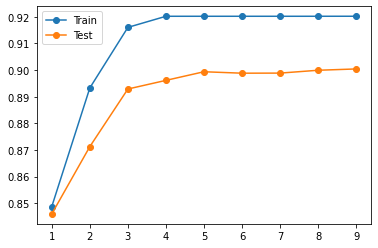

In [8]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)


#Check for overfitting with n_estimators

# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = [1,2,3,4,5,6,7,8,9]
# evaluate a decision tree for estimator
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=i, learning_rate = learningRate, n_estimators=nEstimator, random_state=23).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = roc_auc_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('tree depth: %.0f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs n_estimator
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()